# Ethereum Proof‑of‑Stake (PoS): Definitions Notebook

This notebook highlights key definitions, mechanisms, and instructor-ready questions based on Ethereum.org documentation for Proof‑of‑Stake.


## 1) Big Picture: What is PoS?
**Proof‑of‑stake (PoS)** secures Ethereum by having **validators** lock up **staked ETH** and perform two main duties:
- **Propose blocks** (when chosen for a slot)
- **Attest (vote)** on blocks they see as valid and on checkpoint pairs for finality

**Time structure**
- **Slot**: 12 seconds
- **Epoch**: 32 slots (~6.4 minutes)
- A validator is pseudo‑randomly chosen to **propose one block per slot**
- Other validators are assigned into **committees** to **attest** every epoch

**Key thresholds**
- **Activation deposit**: 32 ETH per validator
- **Finality**: requires ≥ **two‑thirds (66%)** of total staked ETH to vote for a checkpoint pair (Casper FFG)
- **Inactivity leak**: kicks in after 4+ epochs without finality to bleed stake from the non‑participating side so the chain can finalize again

**Crypto‑economic security**
- Honest participation earns rewards; faults or malicious behavior incur **penalties** and potentially **slashing**.



## 2) Gasper in one page (LMD‑GHOST + Casper FFG)
**Gasper** is the combination of:
- **LMD‑GHOST** fork‑choice rule for selecting the head of the chain by the **weight of recent attestations**.
- **Casper FFG** finality gadget that reaches **finality** on epoch checkpoints (supermajority links).

**Why two parts?**
- LMD‑GHOST is great for finding the most‑attested head **now**.
- Casper FFG gives **finality guarantees** across epochs, making deep reorgs economically prohibitive.


## 3) Weak Subjectivity
**Subjectivity**: relying on social information to choose among multiple plausible forks.

**Weak Subjectivity Checkpoints**: Same purpose as genesis block. State roots all nodes agree on.

**Weak subjectivity**: only the **initial seed** (a recent trusted checkpoint) is socially obtained; thereafter the chain proceeds **objectively** under the rules.

**Why it matters**
- Prevents **long‑range attacks** where an adversary forges an ancient chain.
- New/returning nodes must sync to a **recent checkpoint** (within the weak‑subjectivity period) to be safe.



## 4) Attestations (the validator’s vote)
Each validator produces an **attestation** per epoch that includes:
- `aggregation_bits` – who signed in the committee
- `data` – `slot`, `index` (committee id), `beacon_block_root` (head), `source` (most recent **justified**), `target` (first block of **current epoch**)
- `signature` – aggregate **BLS** signature

**Aggregation**
- Attestations are aggregated within **subnets** by selected **aggregators**, reducing network load.
- Block proposers include aggregated attestations into their blocks.

**Rewards quick math**
- **Base reward** ~ proportional to validator **effective balance** and inversely proportional to √(total active balance).
- **Inclusion delay**: reward is multiplied by `1/delay` (1 slot delay = full inclusion‑delay reward, 2 slots = 1/2, etc.).


### Attestation Visualized

**Epoch & Slots**
- Epoch ≈ 6.4 min (32 slots).
- Each validator attests once per epoch (assigned to a specific slot).

**Committee & Aggregation**
- Validators are split into slot committees.
- `aggregation_bits` → bitlist where position = validator index in the committee; 1 = signed/participated.

**Attestation Contents**
- `data`:
  - `slot`: slot being attested
  - `index`: committee index at that slot
  - `beacon_block_root`: head of chain (fork choice result)
  - `source`: most recent justified checkpoint
  - `target`: first block of current epoch (checkpoint)
- `signature`: aggregate BLS over the committee’s attestations.

**Lifecycle**
1) Build `data` → 2) flip own bit in `aggregation_bits` → 3) sign & gossip → 4) aggregators combine → 5) proposer includes in block.


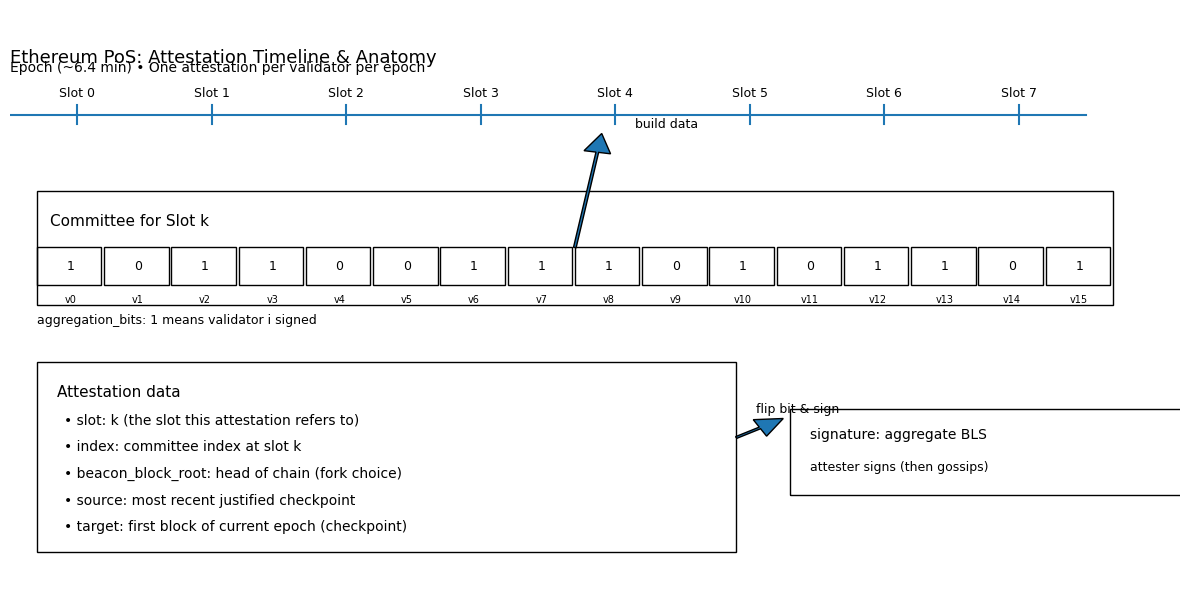

In [3]:
# Visualization: Ethereum PoS attestation anatomy & timeline
# - One epoch (~6.4 min), slots, committee + aggregation_bits
# - Attestation 'data' fields and aggregate BLS signature
# Runs with only matplotlib.

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrow
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(12, 6))

# Timeline (show first 8 slots for readability)
slots_to_show = 8
y_timeline = 5.2
ax.add_line(Line2D([0.5, slots_to_show + 0.5], [y_timeline, y_timeline]))
for s in range(slots_to_show):
    ax.add_line(Line2D([s+1, s+1], [y_timeline-0.1, y_timeline+0.1]))
    ax.text(s+1, y_timeline+0.15, f"Slot {s}", ha='center', va='bottom', fontsize=9)
ax.text(0.5, y_timeline+0.45, "Epoch (~6.4 min) • One attestation per validator per epoch", ha='left', fontsize=10)

# Committee with aggregation_bits (1 = participated)
committee_x, committee_y = 0.7, 3.2
committee_w, committee_h = slots_to_show, 1.2
ax.add_patch(Rectangle((committee_x, committee_y), committee_w, committee_h, fill=False))
ax.text(committee_x+0.1, committee_y+committee_h-0.25, "Committee for Slot k", fontsize=11, va='top')

bits = [1,0,1,1,0,0,1,1,1,0,1,0,1,1,0,1]  # demo bitlist
n_bits = len(bits)
bit_w = committee_w / n_bits
for i, b in enumerate(bits):
    x = committee_x + i*bit_w
    ax.add_patch(Rectangle((x, committee_y+0.2), bit_w-0.02, 0.4, fill=False))
    ax.text(x + bit_w/2, committee_y+0.4, str(b), ha='center', va='center', fontsize=9)
    ax.text(x + bit_w/2, committee_y+0.1, f"v{i}", ha='center', va='top', fontsize=7)

ax.text(committee_x, committee_y-0.1, "aggregation_bits: 1 means validator i signed", fontsize=9, va='top')

# Attestation "data" panel
data_x, data_y = 0.7, 0.6
data_w, data_h = 5.2, 2.0
ax.add_patch(Rectangle((data_x, data_y), data_w, data_h, fill=False))
ax.text(data_x+0.15, data_y+data_h-0.25, "Attestation data", fontsize=11, va='top')
for i, t in enumerate([
    "slot: k (the slot this attestation refers to)",
    "index: committee index at slot k",
    "beacon_block_root: head of chain (fork choice)",
    "source: most recent justified checkpoint",
    "target: first block of current epoch (checkpoint)"
]):
    ax.text(data_x+0.2, data_y+data_h-0.55 - 0.28*i, f"• {t}", fontsize=10, ha='left', va='top')

# Aggregate signature box + arrows
sig_x, sig_y = data_x + data_w + 0.4, data_y + 0.6
sig_w, sig_h = 3.2, 0.9
ax.add_patch(Rectangle((sig_x, sig_y), sig_w, sig_h, fill=False))
ax.text(sig_x+0.15, sig_y+sig_h-0.2, "signature: aggregate BLS", fontsize=10, va='top')
ax.text(sig_x+0.15, sig_y+sig_h-0.55, "attester signs (then gossips)", fontsize=9, va='top')

ax.add_patch(FancyArrow(committee_x + committee_w/2, committee_y+0.6, 0.2, 1.2, width=0.02, head_width=0.2, head_length=0.2, length_includes_head=True))
ax.text(committee_x + committee_w/2 + 0.45, committee_y+1.9, "build data", fontsize=9, va='center')
ax.add_patch(FancyArrow(data_x + data_w, data_y+1.2, 0.35, 0.2, width=0.02, head_width=0.2, head_length=0.2, length_includes_head=True))
ax.text(data_x + data_w + 0.15, data_y+1.5, "flip bit & sign", fontsize=9, va='center')

ax.text(0.5, 5.7, "Ethereum PoS: Attestation Timeline & Anatomy", fontsize=13, ha='left', va='bottom')

ax.set_xlim(0.5, slots_to_show + 1.2)
ax.set_ylim(0.3, 6.3)
ax.axis('off')
plt.tight_layout()
plt.show()

# To save: uncomment below
# plt.gcf().savefig("/mnt/data/attestation_visual.png", dpi=200, bbox_inches="tight")



## 5) Rewards, Penalties, and Slashing
**Rewards**
- Components (weights out of 64): timely **source** (14), **target** (26), **head** (14), **sync** (2), **proposer** (8).
- Maximum typical attestation‑only reward per epoch ≈ **(64 − 8 − 2) / 64 = 6.75/8 × base_reward**; if you also propose a block and/or join a sync committee you can earn more.

**Penalties**
- Missing **source** or **target** vote incurs a penalty equal to the missed reward (head vote has no penalty).
- No penalty for failing to propose a block (you just miss its reward).

**Slashing (forced exit over ~36 days)**
- Offenses include: proposing two blocks for the same slot, **double‑vote**, or **surround vote**.
- Immediate small burn, then **correlation penalty** at ~Day 18 scales up when many validators are slashed together (could reach 100% of effective balance in mass events).
- **Inactivity leak** after 4+ epochs without finality bleeds stake from the minority so the majority can regain ≥2/3 for finality.


In [4]:
"""
Ethereum PoS Rewards: teaching demo (not a full client implementation)

What this shows (per epoch):
- base_reward = effective_balance * (base_reward_factor / (base_rewards_per_epoch * sqrt(sum_active_balance)))
- component weights (source/target/head/sync/proposer) out of 64
- inclusion_delay_reward = base_reward * (1 / delay_slots)
- proposer attestation reward = (8/64) * base_reward per valid included attestation
- proposer slashing inclusion reward = slashed_effective_balance / 512

References: Ethereum.org "Proof‑of‑stake — Rewards & penalties"
(components, weights, inclusion delay, proposer reward, slashing reward).
"""

from math import sqrt
from dataclasses import dataclass

# ---- Protocol constants (per ethereum.org) ----------------------------------
BASE_REWARD_FACTOR = 64           # base_reward_factor
BASE_REWARDS_PER_EPOCH = 4        # base_rewards_per_epoch

# Component weights (sum = 64)
TIMELY_SOURCE_WEIGHT = 14
TIMELY_TARGET_WEIGHT = 26
TIMELY_HEAD_WEIGHT   = 14
SYNC_REWARD_WEIGHT   = 2
PROPOSER_WEIGHT      = 8
TOTAL_WEIGHT         = (
    TIMELY_SOURCE_WEIGHT +
    TIMELY_TARGET_WEIGHT +
    TIMELY_HEAD_WEIGHT +
    SYNC_REWARD_WEIGHT +
    PROPOSER_WEIGHT
)
assert TOTAL_WEIGHT == 64

# ---- Helper: base reward -----------------------------------------------------
def base_reward(effective_balance_eth: float, sum_active_balance_eth: float) -> float:
    """
    Compute base_reward per epoch for a validator.

    Args:
        effective_balance_eth: validator's effective balance (typically <= 32 ETH)
        sum_active_balance_eth: total active validators' balance (ETH)

    Returns:
        base_reward in ETH per epoch (teaching-scale number).
    """
    if effective_balance_eth <= 0 or sum_active_balance_eth <= 0:
        return 0.0
    return effective_balance_eth * (
        BASE_REWARD_FACTOR / (BASE_REWARDS_PER_EPOCH * sqrt(sum_active_balance_eth))
    )

# ---- Per-epoch attestation & other rewards ----------------------------------
@dataclass
class EpochOutcome:
    timely_source: bool = True
    timely_target: bool = True
    timely_head:   bool = True
    in_sync_committee: bool = False
    was_proposer: bool = False
    inclusion_delay_slots: int = 1  # 1 = best case, 2 halves, etc.

def component_weight_sum(outcome: EpochOutcome) -> int:
    w = 0
    if outcome.timely_source: w += TIMELY_SOURCE_WEIGHT
    if outcome.timely_target: w += TIMELY_TARGET_WEIGHT
    if outcome.timely_head:   w += TIMELY_HEAD_WEIGHT
    if outcome.in_sync_committee: w += SYNC_REWARD_WEIGHT
    if outcome.was_proposer:      w += PROPOSER_WEIGHT
    return w

def attestor_reward(br: float, outcome: EpochOutcome) -> float:
    """
    Attestor’s own per-epoch reward for flags + inclusion delay.
    Note: inclusion_delay applies to the attestation portion; here we
    multiply the entire flag-based portion by 1/delay to illustrate the idea.
    """
    flags_weight = component_weight_sum(
        EpochOutcome(
            timely_source=outcome.timely_source,
            timely_target=outcome.timely_target,
            timely_head=outcome.timely_head,
            in_sync_committee=outcome.in_sync_committee,
            was_proposer=False,  # proposer weight is separate from attestor’s flags
            inclusion_delay_slots=outcome.inclusion_delay_slots,
        )
    )
    flag_fraction = flags_weight / TOTAL_WEIGHT
    delay = max(1, int(outcome.inclusion_delay_slots))
    inclusion_multiplier = 1.0 / delay
    return br * flag_fraction * inclusion_multiplier

def proposer_attestation_reward_per_attestation(br: float) -> float:
    """
    Proposer earns 8/64 * base_reward for each valid attestation included.
    """
    return (PROPOSER_WEIGHT / TOTAL_WEIGHT) * br  # 8/64 * br

def proposer_slashing_inclusion_bonus(slashed_effective_balance_eth: float) -> float:
    """
    Proposer bonus for including valid slashing evidence:
    slashed_validator_effective_balance / 512
    """
    return slashed_effective_balance_eth / 512.0

# ---- Demo scenarios ----------------------------------------------------------
def demo():
    # Example network & validator
    sum_active_balance_eth = 1_000_000.0  # total active stake (ETH), example scale
    effective_balance_eth  = 32.0         # validator’s effective balance (max typical)
    br = base_reward(effective_balance_eth, sum_active_balance_eth)
    print(f"Base reward per epoch (ETH): {br:.8f}")

    # Case A: Attestor (not proposer, not in sync committee), perfect flags, delay=1
    outcome_A = EpochOutcome(
        timely_source=True, timely_target=True, timely_head=True,
        in_sync_committee=False, was_proposer=False, inclusion_delay_slots=1
    )
    a_reward = attestor_reward(br, outcome_A)
    print(f"Attestor reward (perfect flags, delay=1): {a_reward:.8f} ETH "
          f"(≈ {( (TIMELY_SOURCE_WEIGHT+TIMELY_TARGET_WEIGHT+TIMELY_HEAD_WEIGHT)/TOTAL_WEIGHT )*br:.8f} ETH)")

    # Case B: Same, but delay = 2 slots → reward halves
    outcome_B = EpochOutcome(
        timely_source=True, timely_target=True, timely_head=True,
        in_sync_committee=False, was_proposer=False, inclusion_delay_slots=2
    )
    b_reward = attestor_reward(br, outcome_B)
    print(f"Attestor reward (perfect flags, delay=2): {b_reward:.8f} ETH")

    # Case C: In sync committee this epoch (adds +2 weight)
    outcome_C = EpochOutcome(
        timely_source=True, timely_target=True, timely_head=True,
        in_sync_committee=True, was_proposer=False, inclusion_delay_slots=1
    )
    c_reward = attestor_reward(br, outcome_C)
    print(f"Attestor reward (with sync committee, delay=1): {c_reward:.8f} ETH")

    # Case D: Proposer reward from included attestations (e.g., 120 attestations)
    attestations_included = 120
    proposer_per_att = proposer_attestation_reward_per_attestation(br)
    proposer_total = proposer_per_att * attestations_included
    print(f"Proposer reward from {attestations_included} included attestations: "
          f"{proposer_total:.8f} ETH (per att: {proposer_per_att:.8f} ETH)")

    # Case E: Proposer includes slashing evidence (example: slashed validator 32 ETH effective)
    slashed_eff_bal = 32.0
    slash_bonus = proposer_slashing_inclusion_bonus(slashed_eff_bal)
    print(f"Proposer slashing inclusion bonus: {slash_bonus:.8f} ETH")

if __name__ == "__main__":
    demo()


Base reward per epoch (ETH): 0.51200000
Attestor reward (perfect flags, delay=1): 0.43200000 ETH (≈ 0.43200000 ETH)
Attestor reward (perfect flags, delay=2): 0.21600000 ETH
Attestor reward (with sync committee, delay=1): 0.44800000 ETH
Proposer reward from 120 included attestations: 7.68000000 ETH (per att: 0.06400000 ETH)
Proposer slashing inclusion bonus: 0.06250000 ETH



## 6) Attack & Defense (high‑level)
Potential attacks and mitigations include:
- **51%‑style influence**: very costly in PoS; community can coordinate to ignore attacker’s fork and **slash** attackers.
- **Short‑range reorgs**: mitigated by proposer boosting and attestation deadlines.
- **Bouncing / balancing / avalanche** timing attacks: addressed with fork‑choice rules and message handling.
- **Long‑range attacks**: neutralized by **finality** + **weak subjectivity** requirements.



## 7) Keys in Ethereum PoS
Validators use multiple keys/roles with best practices such as:
- **Signing key** (hot): used for proposing/attesting; must be secure and online.
- **Withdrawal key** (cold): controls withdrawals (to 0x01 / 0x00 withdrawal credentials depending on setup); should be kept offline.
- Use **mnemonics** and secure key management; separate duties to limit blast radius.



## 8) PoS vs PoW (trade‑offs)
- **Security cost to attack**: PoS requires acquiring and risking (via potential slashing) a large share of **staked ETH** (>33% to meaningfully disrupt, ≥66% to finalize your view). Repeated attacks are prohibitively expensive.
- **Complexity**: PoS is more complex, but implemented by **diverse clients** across languages and was tested for years via the Beacon Chain before **The Merge**.
- **Decentralization**: PoS avoids hardware arms races; **32 ETH** per validator but **home staking** and **pools** exist. LSDs raise centralization concerns that client and operator diversity aim to mitigate.
- **Sustainability**: PoS reduced Ethereum’s energy usage by ~**99.98%** vs PoW.
- **Issuance**: Lower security spend enables lower issuance; burning base fees can even make ETH deflationary at times.



## 9) Block Proposal (per slot)
- One validator is selected to **propose** a block each 12‑second slot.
- Proposer assembles an **execution payload** (transactions) and consensus data (attestations, slashings, etc.) into a **beacon block**.
- Other validators re‑execute the payload and, if valid, **attest** to the head and checkpoints.



## 10) Mini demos (no external deps)

### A) Slot/Epoch utilities
Quick helpers to convert between slots and epochs.

### B) Simple committee sampling demo
Toy example to show how validators might be split into committees each epoch (purely illustrative, not spec‑accurate).

> These are pedagogical; consensus clients implement the actual RANDAO‑based selections per spec.


In [1]:

# A) Slot/Epoch utilities
SLOTS_PER_EPOCH = 32
SECONDS_PER_SLOT = 12

def epoch_to_slot(epoch: int) -> int:
    return epoch * SLOTS_PER_EPOCH

def slot_to_epoch(slot: int) -> int:
    return slot // SLOTS_PER_EPOCH

def seconds_for_slots(n_slots: int) -> int:
    return n_slots * SECONDS_PER_SLOT

# Examples
print("Epoch 100 starts at slot:", epoch_to_slot(100))
print("Slot 4096 is in epoch:", slot_to_epoch(4096))
print("Time for 5 slots (s):", seconds_for_slots(5))


Epoch 100 starts at slot: 3200
Slot 4096 is in epoch: 128
Time for 5 slots (s): 60


In [2]:

# B) Simple committee sampling demo (toy example)
import random

def sample_committees(total_validators=2048, committees_per_epoch=64, seed=42):
    rng = random.Random(seed)
    validators = list(range(total_validators))
    rng.shuffle(validators)
    size = total_validators // committees_per_epoch
    committees = [validators[i*size:(i+1)*size] for i in range(committees_per_epoch)]
    return committees

committees = sample_committees()
print("Number of committees:", len(committees))
print("First 3 committees (sizes):", [len(c) for c in committees[:3]])
print("First committee (first 10 validator indices):", committees[0][:10])


Number of committees: 64
First 3 committees (sizes): [32, 32, 32]
First committee (first 10 validator indices): [908, 915, 803, 1173, 2026, 970, 1961, 1297, 1211, 183]



## 11) Instructor Questions (with short answers below)

> **Tip:** Use these as cold‑calls, clicker questions, or quick‑checks. Hide the answers in class and reveal later.

1. **Define a slot and an epoch in Ethereum PoS. How long is each, and how many slots per epoch?**
2. **What two duties do validators perform?**
3. **What is the minimum deposit to activate a validator?**
4. **What does the LMD‑GHOST rule do? What does Casper FFG provide?**
5. **What is an attestation’s `source` and `target`?**
6. **Name the five reward components and which three are “participation flags.”**
7. **What behavior triggers slashing? What is the correlation penalty?**
8. **When does the inactivity leak activate and what’s its purpose?**
9. **Explain weak subjectivity and why it prevents long‑range attacks.**
10. **List two advantages PoS has over PoW from sustainability or security‑economics.**
11. **Why does PoS require an initial trusted checkpoint for new/returning nodes?**
12. **What information flows from execution client to consensus client during block proposal?**
13. **finality requires a two-thirds agreement that a block is canonical, an attacker cannot possibly create an alternative finalized chain without:**



### Suggested Answers (concise)
1. **Slot**: 12 seconds; **Epoch**: 32 slots (~6.4 minutes).  
2. **Propose blocks** (when selected) and **attest** to head/ checkpoints.  
3. **32 ETH**.  
4. **LMD‑GHOST** selects the head based on latest attestation weights; **Casper FFG** gives epoch‑level **finality** via supermajority links.  
5. **Source** = most recent **justified** checkpoint; **Target** = first block of the **current epoch**.  
6. **Source, Target, Head** are the three participation flags; other components: **sync committee** and **proposer** rewards.  
7. **Double block**, **double vote**, or **surround vote** → **slashing**; **correlation penalty** grows with the number of slashings in the window.  
8. After **≥4 epochs** without finality; it **bleeds stake** from the inactive side until ≥2/3 can finalize.  
9. New nodes use a **recent checkpoint** (socially obtained) so very old forged histories can’t trick them.  
10. **~99.98%** lower energy; **attacks cost staked ETH** that can be **slashed** (one‑shot vs. reusable mining hardware).  
11. Because PoS is **weakly subjective**—you must start from a recent, socially agreed checkpoint.  
12. Proposer builds **execution payload** (txs/state changes) and consensus data (**attestations, slashings, etc.**) into a **beacon block** shared to peers.
13. Owning or manipulating 2/3 of the total staked ether. And, destroying at least one-third of the total staked ether.



---

### Source Mapping (for further reading)
- PoS overview: Proof‑of‑stake (validators, slots/epochs, finality, inactivity leak).  
- Attestations: components, aggregation, inclusion‑delay reward, base reward.  
- Rewards/Penalties/Slashing: reward weights, penalties, 36‑day forced exit, correlation penalty, inactivity leak details.  
- Weak subjectivity: definition, rationale, and security implications.  
- PoS vs PoW: security economics, decentralization, sustainability, issuance.  
- Block proposal: proposer/committee roles, execution payload + beacon block.

> See Ethereum.org docs linked in the assignment for full context.
